In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def loadData(fileName):
    return np.mat(np.loadtxt(fileName))
def splitDataSet(dataSet, feature, val):
    data1 = dataSet[np.nonzero(dataSet[:, feature] >= val)[0]]
    data2 = dataSet[np.nonzero(dataSet[:, feature] < val)[0]]
    return data1, data2
def Leaf(dataSet):
    return np.mean(dataSet[:, -1]) # a mean value of all labels as one leaf
def Error(dataSet):
    return np.var(dataSet[:, -1]) * dataSet.shape[0]
def createTree(dataSet, ops = (1, 4), typeLeaf = Leaf, typeError = Error):
    feat, val = bestSplit(dataSet, ops, typeLeaf, typeError)
    if feat == None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = splitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, ops, typeLeaf, typeError)
    retTree['right'] = createTree(rSet, ops, typeLeaf, typeError)
    return retTree
def bestSplit(dataSet, ops, typeLeaf = Leaf, typeError = Error):
    tolS = ops[0]
    tolN = ops[1]
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1: # same class
        return None, typeLeaf(dataSet)
    m, n = dataSet.shape
    E = typeError(dataSet)
    minError = np.Inf
    bestIndex = 0
    bestValue = dataSet[0, 0]
    for index in range(n-1):
        for splitVal in set(dataSet[:, index].T.tolist()[0]):
            dataSet1, dataSet2 = splitDataSet(dataSet, index, splitVal)
            if dataSet1.shape[0] < tolN or dataSet2.shape[0] < tolN:
                continue
            newE = typeError(dataSet1) + typeError(dataSet2)
            if newE < minError:
                minError = newE
                bestIndex = index
                bestValue = splitVal
    if (E - minError) < tolS:
        return None, typeLeaf(dataSet)
    return bestIndex, bestValue
def isTree(obj):
    return type(obj).__name__ == 'dict'
def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['right'] + tree['left']) / 2
def Prune(tree, testData):
    if testData.shape[0] == 0:
        return getMean(tree)
    if isTree(tree['right']) or isTree(tree['left']):
        lSet, rSet = splitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['right']):
        tree['right'] = Prune(tree['right'], rSet)
    if isTree(tree['left']):
        tree['left'] = Prune(tree['left'], lSet)
    if not isTree(tree['right']) and not isTree(tree['left']):
        lSet, rSet = splitDataSet(testData, tree['spInd'], tree['spVal'])
        errorBeforeMerge = float((rSet[:, -1] - tree['right']).T * (rSet[:, -1] - tree['right'])) + \
                           float((lSet[:, -1] - tree['left']).T * (lSet[:, -1] - tree['left']))
        mergeValue = getMean(tree)
        errorAfterMerge = float((testData[:, -1] - mergeValue).T * (testData[:, -1] - mergeValue))
        if errorBeforeMerge > errorAfterMerge:
            print('Merge')
            return mergeValue
        else:
            return tree
    return tree
def linearSolve(dataSet):
    m, n = dataSet.shape
    X = np.mat(np.ones((m, n)))
    Y = np.mat(np.ones((m, 1)))
    X[:, 1:] = dataSet[:, :-1]
    Y = dataSet[:, -1]
    xTx = X.T * X
    if np.linalg.det(xTx) == 0:
        raise NameError('cannot do inverse')
    ws = xTx.I * X.T * Y
    return ws, X, Y
def modelLeaf(dataSet):
    ws, X, Y = linearSolve(dataSet)
    return ws
def modelError(dataSet):
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    return float((yHat - Y).T * (yHat - Y))
def regressionTreePredict(model, inputData):
    return float(model)
def modelTreePredict(model, inputData):
    m, n = inputData.shape
    X = np.mat(np.ones((1, n+1)))
    X[:, 1:] = inputData
    return X * model
def treeForecast(tree, inputData, modelType = regressionTreePredict):
    if not isTree(tree):
        return modelType(tree, inputData)
    if inputData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']):
            return treeForecast(tree['left'], inputData, modelType)
        else:
            return modelType(tree['left'], inputData)
    else:
        if isTree(tree['right']):
            return treeForecast(tree['right'], inputData, modelType)
        else:
            return modelType(tree['right'], inputData)
def Forecast(tree, testData, modelType = regressionTreePredict):
    m, n = testData.shape
    yHat = np.mat(np.ones((m, 1)))
    for i in range(m):
        yHat[i, 0] = treeForecast(tree, testData[i, :], modelType)
    return yHat
def LinearRegression(trainSet, testSet):
    ws, X, Y = linearSolve(trainSet)
    m, n = testSet.shape
    yHat = np.insert(testSet[:,:-1].astype(float), obj = 0, values = 1, axis = 1) * ws
    return np.corrcoef(yHat, testSet[:, -1], rowvar  = 0)

In [23]:
createTree(loadData('exp2.txt'), (1, 10))

{'left': {'left': {'left': {'left': 11.7087684,
    'right': 10.9151416,
    'spInd': 0,
    'spVal': 0.946702},
   'right': {'left': 10.4038284,
    'right': 9.63600515,
    'spInd': 0,
    'spVal': 0.838332},
   'spInd': 0,
   'spVal': 0.891032},
  'right': {'left': {'left': 8.897704545454546,
    'right': 8.3251968,
    'spInd': 0,
    'spVal': 0.721517},
   'right': {'left': 7.778694799999999,
    'right': 7.092208083333333,
    'spInd': 0,
    'spVal': 0.619535},
   'spInd': 0,
   'spVal': 0.66897},
  'spInd': 0,
  'spVal': 0.764962},
 'right': {'left': {'left': {'left': 6.4059265,
    'right': 5.9411895999999995,
    'spInd': 0,
    'spVal': 0.519998},
   'right': 5.0669134,
   'spInd': 0,
   'spVal': 0.466011},
  'right': {'left': 4.39478723076923,
   'right': 3.6660292500000002,
   'spInd': 0,
   'spVal': 0.344263},
  'spInd': 0,
  'spVal': 0.399447},
 'spInd': 0,
 'spVal': 0.574813}

In [24]:
createTree(loadData('exp2.txt'), (1, 10), modelLeaf, modelError)

{'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]]), 'spInd': 0, 'spVal': 0.304401}

In [25]:
Prune(createTree(loadData('ex2.txt'), (0, 1)), loadData('ex2test.txt'))

Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge
Merge


{'left': {'left': {'left': {'left': 92.5239915,
    'right': {'left': {'left': 117.9732555,
      'right': 135.837013,
      'spInd': 0,
      'spVal': 0.960398},
     'right': 111.2013225,
     'spInd': 0,
     'spVal': 0.958512},
    'spInd': 0,
    'spVal': 0.968621},
   'right': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': 100.649591,
                'right': 73.520802,
                'spInd': 0,
                'spVal': 0.952833},
               'right': 105.752508,
               'spInd': 0,
               'spVal': 0.952377},
              'right': 69.318649,
              'spInd': 0,
              'spVal': 0.949198},
             'right': {'left': {'left': {'left': 100.120253,
                'right': 119.949824,
                'spInd': 0,
                'spVal': 0.944221},
               'right': {'left': 65.548418,
                'right': {'left': 115.753994,
                 'right': {'left': {'left':

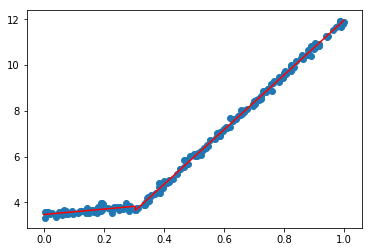

In [26]:
tree = createTree(loadData('exp2.txt'), (1, 10), modelLeaf, modelError)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(loadData('exp2.txt')[:, 0].T.tolist()[0], loadData('exp2.txt')[:, 1].T.tolist()[0])
X = np.arange(0, 1, 0.001)
Y = X.copy()
Y[X >= tree['spVal']] = tree['left'][0, 0] + X[X >= tree['spVal']] * tree['left'][1, 0]
Y[X < tree['spVal']] = tree['right'][0, 0] + X[X < tree['spVal']] * tree['right'][1, 0]
ax.plot(X, Y, 'red')
plt.show()

[[1.         0.95648839]
 [0.95648839 1.        ]]
[[1.         0.96922032]
 [0.96922032 1.        ]]
[[1.         0.94346842]
 [0.94346842 1.        ]]


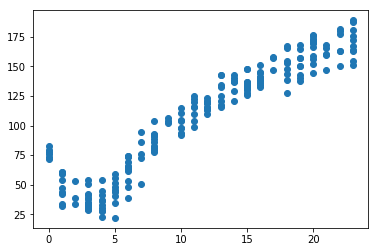

In [27]:
trainSet = loadData('bikeSpeedVsIq_train.txt')
testSet = loadData('bikeSpeedVsIq_test.txt')
regTree = createTree(trainSet, (1, 20))
yHatReg = Forecast(regTree, testSet[:, 0])
print(np.corrcoef(yHatReg, testSet[:, 1], rowvar = 0)) #regression tree
modTree = createTree(trainSet, (1, 20), modelLeaf, modelError)
yHatMod = Forecast(modTree, testSet[:, 0], modelTreePredict)
print(np.corrcoef(yHatMod, testSet[:, -1], rowvar = 0)) #model tree
# linear regression
print(LinearRegression(trainSet, testSet))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(testSet[:, 0].T.tolist()[0], testSet[:, 1].T.tolist()[0])
plt.show()